<a href="https://colab.research.google.com/github/Sujithasunny/dlbrain/blob/main/idp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Dropout, Add, Concatenate, Input, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir = "/content/drive/MyDrive/idp/Training"
test_dir = "/content/drive/MyDrive/idp/Testing"

# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, brightness_range=[0.8,1.2],
                                   horizontal_flip=True, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)



In [ ]:
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=16,
                                                    class_mode='categorical', subset='training')

val_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=16,
                                                  class_mode='categorical', subset='validation')

test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=16,
                                                  class_mode='categorical')

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


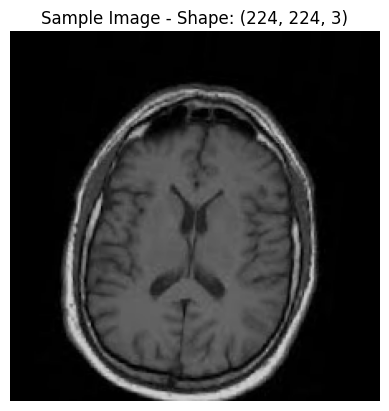

In [ ]:
sample_image, sample_label = next(train_generator)
plt.imshow(sample_image[0])
plt.title(f"Sample Image - Shape: {sample_image[0].shape}")
plt.axis("off")
plt.show()

In [ ]:
class_counts = train_generator.class_indices
print("Class Labels:", class_counts)
num_classes = len(class_counts)

image_counts = {label: len(os.listdir(os.path.join(train_dir, label))) for label in class_counts}
print("Class Distribution:", image_counts)

Class Labels: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Class Distribution: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}


In [ ]:
def inception_block(x, filters):
    conv1x1 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    conv3x3 = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    conv5x5 = Conv2D(filters, (5, 5), padding='same', activation='relu')(x)
    merged = Concatenate()([conv1x1, conv3x3, conv5x5])
    return merged

In [ ]:
input_shape = (224, 224, 3)
input_layer = Input(shape=input_shape)

In [ ]:
x1 = inception_block(input_layer, 32)
skip1 = Conv2D(96, (1, 1), padding='same', activation='relu')(input_layer)  # Match 96
x1 = Add()([x1, skip1])

x2 = inception_block(x1, 64)
skip2 = Conv2D(192, (1, 1), padding='same', activation='relu')(x1)  # Match 192
x2 = Add()([x2, skip2])

x3 = inception_block(x2, 128)
skip3 = Conv2D(384, (1, 1), padding='same', activation='relu')(x2)  # Match 384
x3 = Add()([x3, skip3])

In [ ]:
gap = GlobalAveragePooling2D()(x3)

# Fully Connected Layers
x = Dense(512)(gap)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.5)(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.5)(x)

output_layer = Dense(4, activation='softmax')(x)

In [ ]:
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])




In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model and save the history
history = model.fit(train_generator, validation_data=val_generator, epochs=20, callbacks=[callback])

# Evaluate model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 1431s 5s/step - accuracy: 0.4239 - loss: 1.4682 - val_accuracy: 0.4557 - val_loss: 1.2154
Epoch 2/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 253s 885ms/step - accuracy: 0.4921 - loss: 1.2257 - val_accuracy: 0.5416 - val_loss: 1.1610
Epoch 3/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 253s 883ms/step - accuracy: 0.5548 - loss: 1.0973 - val_accuracy: 0.4110 - val_loss: 1.3339
Epoch 4/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 252s 882ms/step - accuracy: 0.6163 - loss: 0.9437 - val_accuracy: 0.4391 - val_loss: 1.4385
Epoch 5/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 253s 882ms/step - accuracy: 0.6580 - loss: 0.8567 - val_accuracy: 0.4514 - val_loss: 1.8245
Epoch 6/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 251s 878ms/step - accuracy: 0.6503 - loss: 0.8439 - val_accuracy: 0.5653 - val_loss: 1.0603
Epoch 7/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 251s 879ms/step - accuracy: 0.6750 - loss: 0.7985 - val_accuracy: 0.6652 - val_loss: 0.9372
Epoch 8/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 251s 879ms/step - accuracy: 0.7003 - l

Inception v3

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

train_dir = "/content/drive/MyDrive/idp/Training"
test_dir = "/content/drive/MyDrive/idp/Testing"

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(299, 299), batch_size=32, class_mode='categorical', subset='training')
val_generator = train_datagen.flow_from_directory(train_dir, target_size=(299, 299), batch_size=32, class_mode='categorical', subset='validation')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(299, 299), batch_size=32, class_mode='categorical')

# Load Pretrained InceptionV3 Model
base_model = InceptionV3(include_top=False, input_shape=(299, 299, 3), weights="imagenet")
base_model.trainable = False  # Freeze base layers initially

# Add Custom Layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Fully Connected Layers
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.6)(x)

x = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.6)(x)

output_layer = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

# Train with Early Stopping & Fine-Tuning
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(train_generator, validation_data=val_generator, epochs=20, callbacks=[callback])

# Fine-Tune Pretrained Model
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Freeze first few layers
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

history_finetune = model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=[callback])

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.3859 - loss: 13.1335 - val_accuracy: 0.6442 - val_loss: 12.1618
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.6622 - loss: 11.9921 - val_accuracy: 0.7003 - val_loss: 11.5745
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.7027 - loss: 11.4188 - val_accuracy: 0.7029 - val_loss: 11.0477
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.7604 - loss: 10.8465 - val_accuracy: 0.7187 - val_loss: 10.5639
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.7610 - loss: 10.3805 - val_accuracy: 0.7318 - val_loss: 10.0950
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.7713 - loss: 9.8786 - val_accuracy: 0.7309 - val_loss: 9.6699
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.21      0.19      0.20       300
  meningioma       0.25      0.22      0.23       306
     notumor       0.31      0.34      0.32       405
   pituitary       0.21      0.24      0.23       300

    accuracy                           0.25      1311
   macro avg       0.25      0.25      0.25      1311
weighted avg       0.25      0.25      0.25      1311

Confusion Matrix:
[[ 58  63  95  84]
 [ 64  67 100  75]
 [ 88  75 137 105]
 [ 60  61 107  72]]


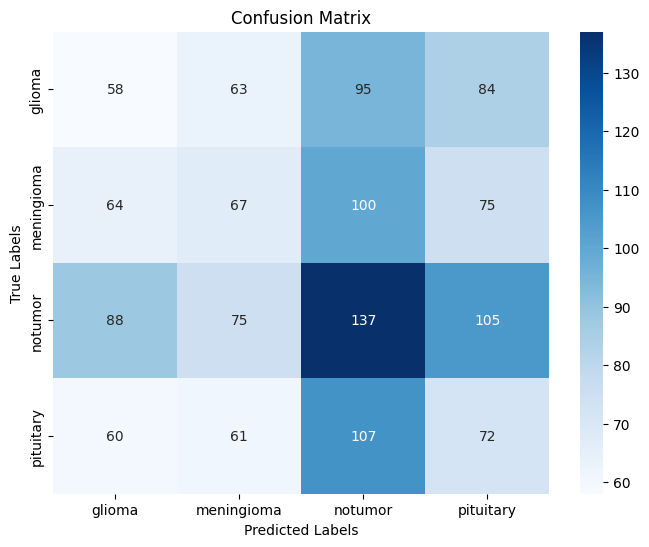

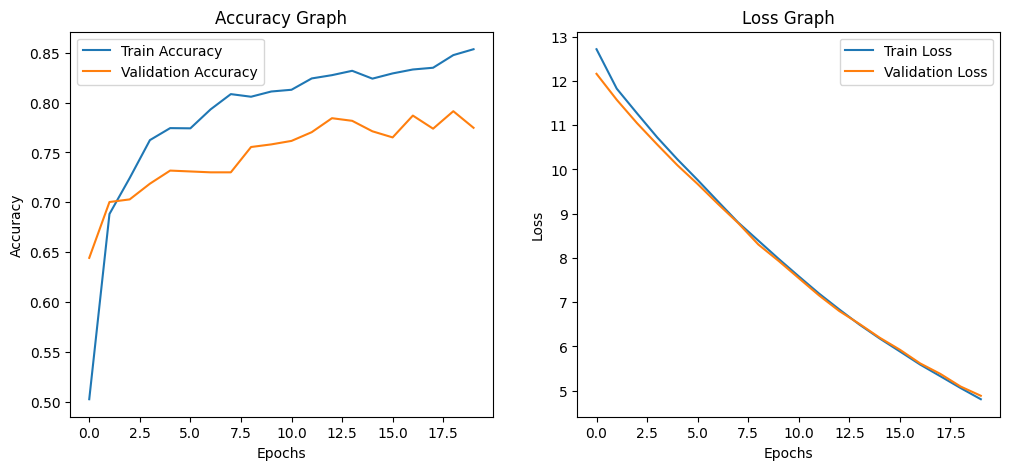

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Plot Accuracy and Loss Graphs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Graph')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Graph')

plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

train_dir = "/content/drive/MyDrive/idp/Training"
test_dir = "/content/drive/MyDrive/idp/Testing"

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', subset='training')
val_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', subset='validation')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)

# Load Pretrained ResNet50 Model
base_model = ResNet50(include_top=False, input_shape=(224, 224, 3), weights="imagenet")
base_model.trainable = False  # Freeze base layers initially

# Add Custom Layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Fully Connected Layers
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.6)(x)

x = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.6)(x)

output_layer = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

# Train with Early Stopping & Fine-Tuning
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(train_generator, validation_data=val_generator, epochs=20, callbacks=[callback])

# Fine-Tune Pretrained Model
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Freeze first few layers
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

history_finetune = model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=[callback])

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Evaluate Model

In [ ]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Plot Accuracy and Loss Graphs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Graph')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Graph')

plt.show()


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 64)   │            256 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 32)   │          2,080 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 224, 224, 32)   │         18,464 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 224, 224, 32)   │         51,232 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 224, 224, 64)   │          4,160 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 224, 224, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 224, 224, 64)   │        102,464 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 224, 224, 128)  │          8,320 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 224, 224, 128)  │         73,856 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 224, 224, 128)  │        204,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 224, 224, 96)   │              0 │ conv2d_1[0][0],        │
│                           │                        │                │ conv2d_2[0][0],        │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 224, 224, 192)  │              0 │ conv2d_4[0][0],        │
│ (Concatenate)             │                        │                │ conv2d_5[0][0],        │
│                           │                        │                │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 224, 224, 384)  │              0 │ conv2d_7[0][0],        │
│ (Concatenate)             │                        │                │ conv2d_8[0][0],        │
│                           │                        │                │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 224, 224, 736)  │              0 │ concatenate[0][0],     │
│ (Concatenate)             │                        │                │ concatenate_1[0][0],   │
│                           │                        │                │ concatenate_2[0][0],   │
│                           │                        │                │ conv2d[0][0]           │
├──────────────────────

 Total params: 1,015,460 (3.87 MB)

 Trainable params: 1,013,924 (3.87 MB)

 Non-trainable params: 1,536 (6.00 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1597s 5s/step - accuracy: 0.4912 - loss: 1.2469 - val_accuracy: 0.4347 - val_loss: 1.2817 - learning_rate: 1.0000e-04
Epoch 2/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 123s 431ms/step - accuracy: 0.6282 - loss: 0.9487 - val_accuracy: 0.2498 - val_loss: 1.6163 - learning_rate: 1.0000e-04
Epoch 3/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 125s 436ms/step - accuracy: 0.6702 - loss: 0.8733 - val_accuracy: 0.4785 - val_loss: 1.1920 - learning_rate: 1.0000e-04
Epoch 4/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 123s 429ms/step - accuracy: 0.6832 - loss: 0.8170 - val_accuracy: 0.5644 - val_loss: 1.1286 - learning_rate: 1.0000e-04
Epoch 5/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 123s 429ms/step - accuracy: 0.6937 - loss: 0.7682 - val_accuracy: 0.5872 - val_loss: 1.0756 - learning_rate: 1.0000e-04
Epoch 6/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 122s 428ms/step - accuracy: 0.7172 - loss: 0.7263 - val_accuracy: 0.6047 - val_loss: 0.9878 - learning_rate: 1.0000e-04
Epoch 7/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 12

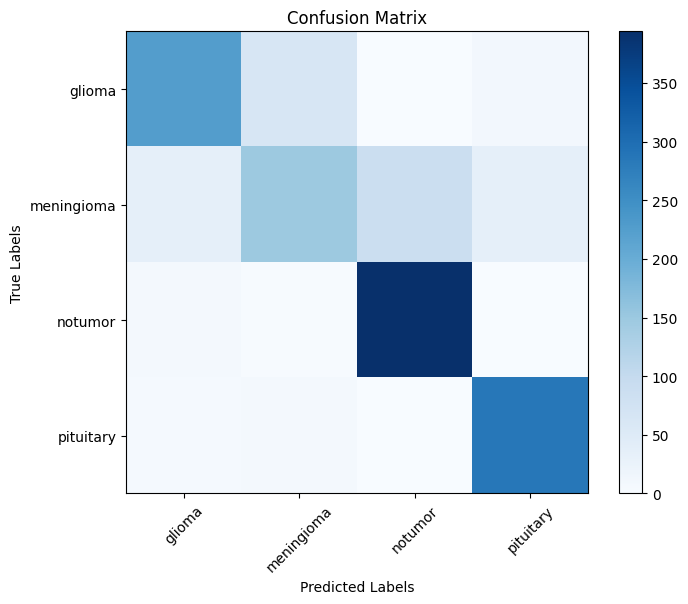

Classification Report:
               precision    recall  f1-score   support

      glioma       0.83      0.75      0.79       300
  meningioma       0.67      0.49      0.56       306
     notumor       0.81      0.97      0.89       405
   pituitary       0.86      0.95      0.91       300

    accuracy                           0.80      1311
   macro avg       0.79      0.79      0.79      1311
weighted avg       0.79      0.80      0.79      1311



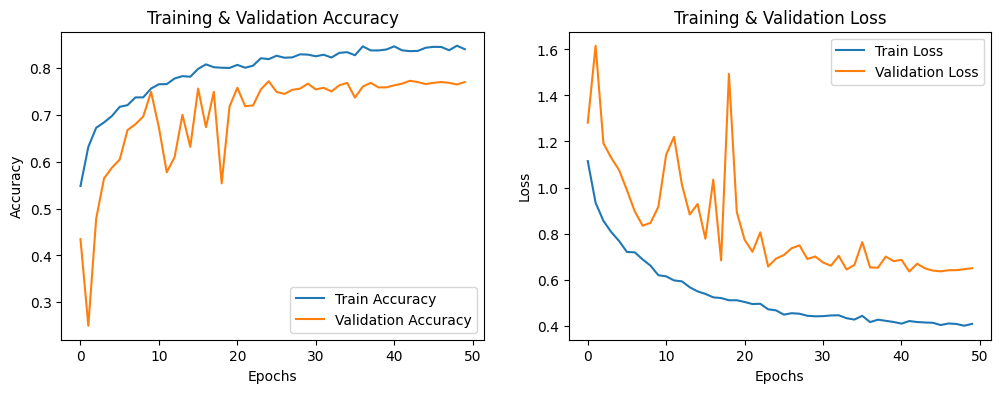

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Dropout, Concatenate, Input, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Load and preprocess data
train_dir = "/content/drive/MyDrive/idp/Training"
test_dir = "/content/drive/MyDrive/idp/Testing"

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=16,
                                                    class_mode='categorical', subset='training')

val_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=16,
                                                  class_mode='categorical', subset='validation')

test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=16,
                                                  class_mode='categorical', shuffle=False)

num_classes = len(train_generator.class_indices)

# Define Inception Block
def inception_block(x, filters):
    conv1x1 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    conv3x3 = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    conv5x5 = Conv2D(filters, (5, 5), padding='same', activation='relu')(x)
    return Concatenate()([conv1x1, conv3x3, conv5x5])

# Model Input
input_layer = Input(shape=(224, 224, 3))

# Skip Connection (Starts after Input Layer)
skip_connection = Conv2D(64, (1, 1), padding='same', activation='relu')(input_layer)

# Parallel Inception Blocks
inception1 = inception_block(skip_connection, 32)
inception2 = inception_block(skip_connection, 64)
inception3 = inception_block(skip_connection, 128)

# Merge Inception Blocks and Skip Connection
merged = Concatenate()([inception1, inception2, inception3, skip_connection])

# Fully Connected Layers
gap = GlobalAveragePooling2D()(merged)

dense1 = Dense(512)(gap)
dense1 = BatchNormalization()(dense1)
dense1 = LeakyReLU()(dense1)
dense1 = Dropout(0.3)(dense1)

dense2 = Dense(256)(dense1)
dense2 = BatchNormalization()(dense2)
dense2 = LeakyReLU()(dense2)
dense2 = Dropout(0.3)(dense2)

output_layer = Dense(num_classes, activation='softmax')(dense2)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

# Callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train Model
history = model.fit(train_generator, validation_data=val_generator, epochs=50, callbacks=[callback, lr_scheduler])

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Get Predictions
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix Plot Without Seaborn
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap="Blues", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=np.arange(num_classes), labels=train_generator.class_indices.keys(), rotation=45)
plt.yticks(ticks=np.arange(num_classes), labels=train_generator.class_indices.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))

# Plot Training & Validation Accuracy/Loss
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")

plt.show()
